In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix, log_loss, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from collections import Counter
from itertools import pairwise
from sklearn.model_selection import cross_validate
import tensorflow as tf
import matplotlib.cm as cm

In [235]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', palette='viridis')

In [236]:
df = pd.read_csv(
    "LSTM-Multivariate_pollution.csv")  # .drop(columns=["date"])
print(df.shape)
df.head()

(43800, 9)


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [238]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


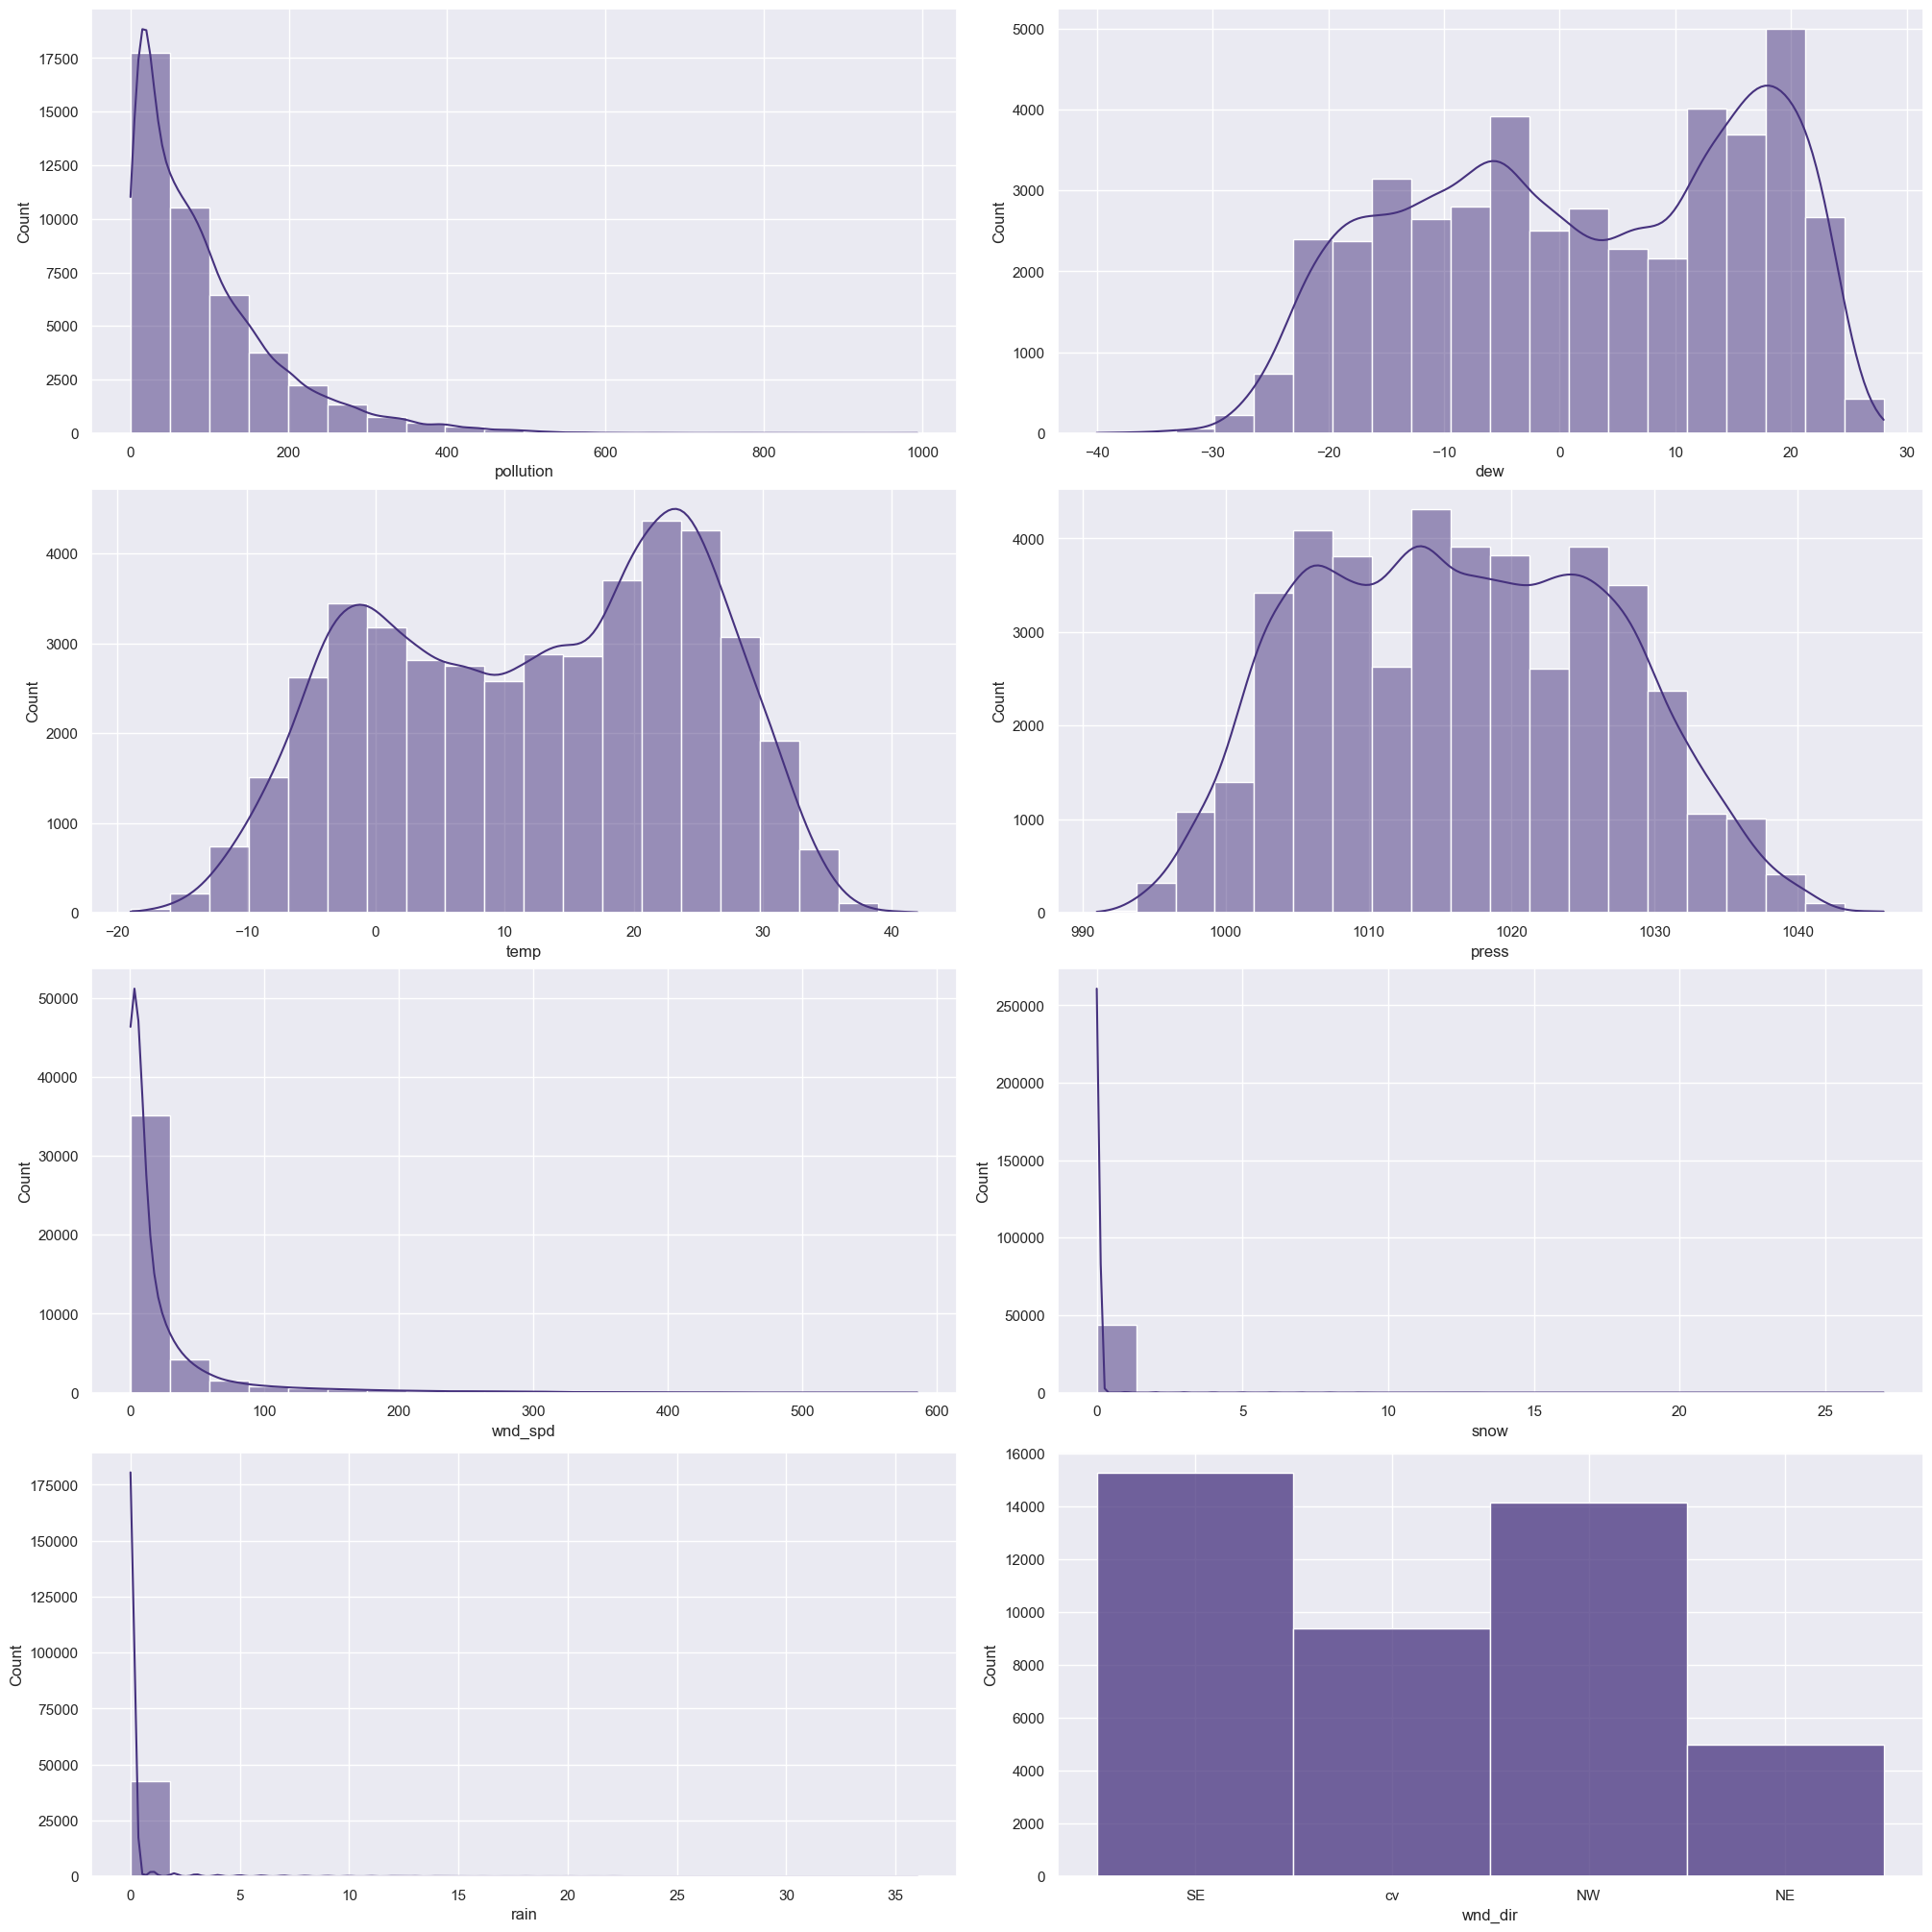

In [239]:
numerical = ['pollution',	'dew',	'temp',	'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(4, 2,
                        figsize=(20, 20), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.histplot(x=f, data=df,  kde=True,
                 ax=axs[i//2][i % 2], bins=20,
                 palette=sns.color_palette("viridis", 2))
sns.histplot(x='wnd_dir', data=df)

plt.show()

In [240]:
df['temp'].values

array([-4., -4., -5., ..., -3., -4., -3.])

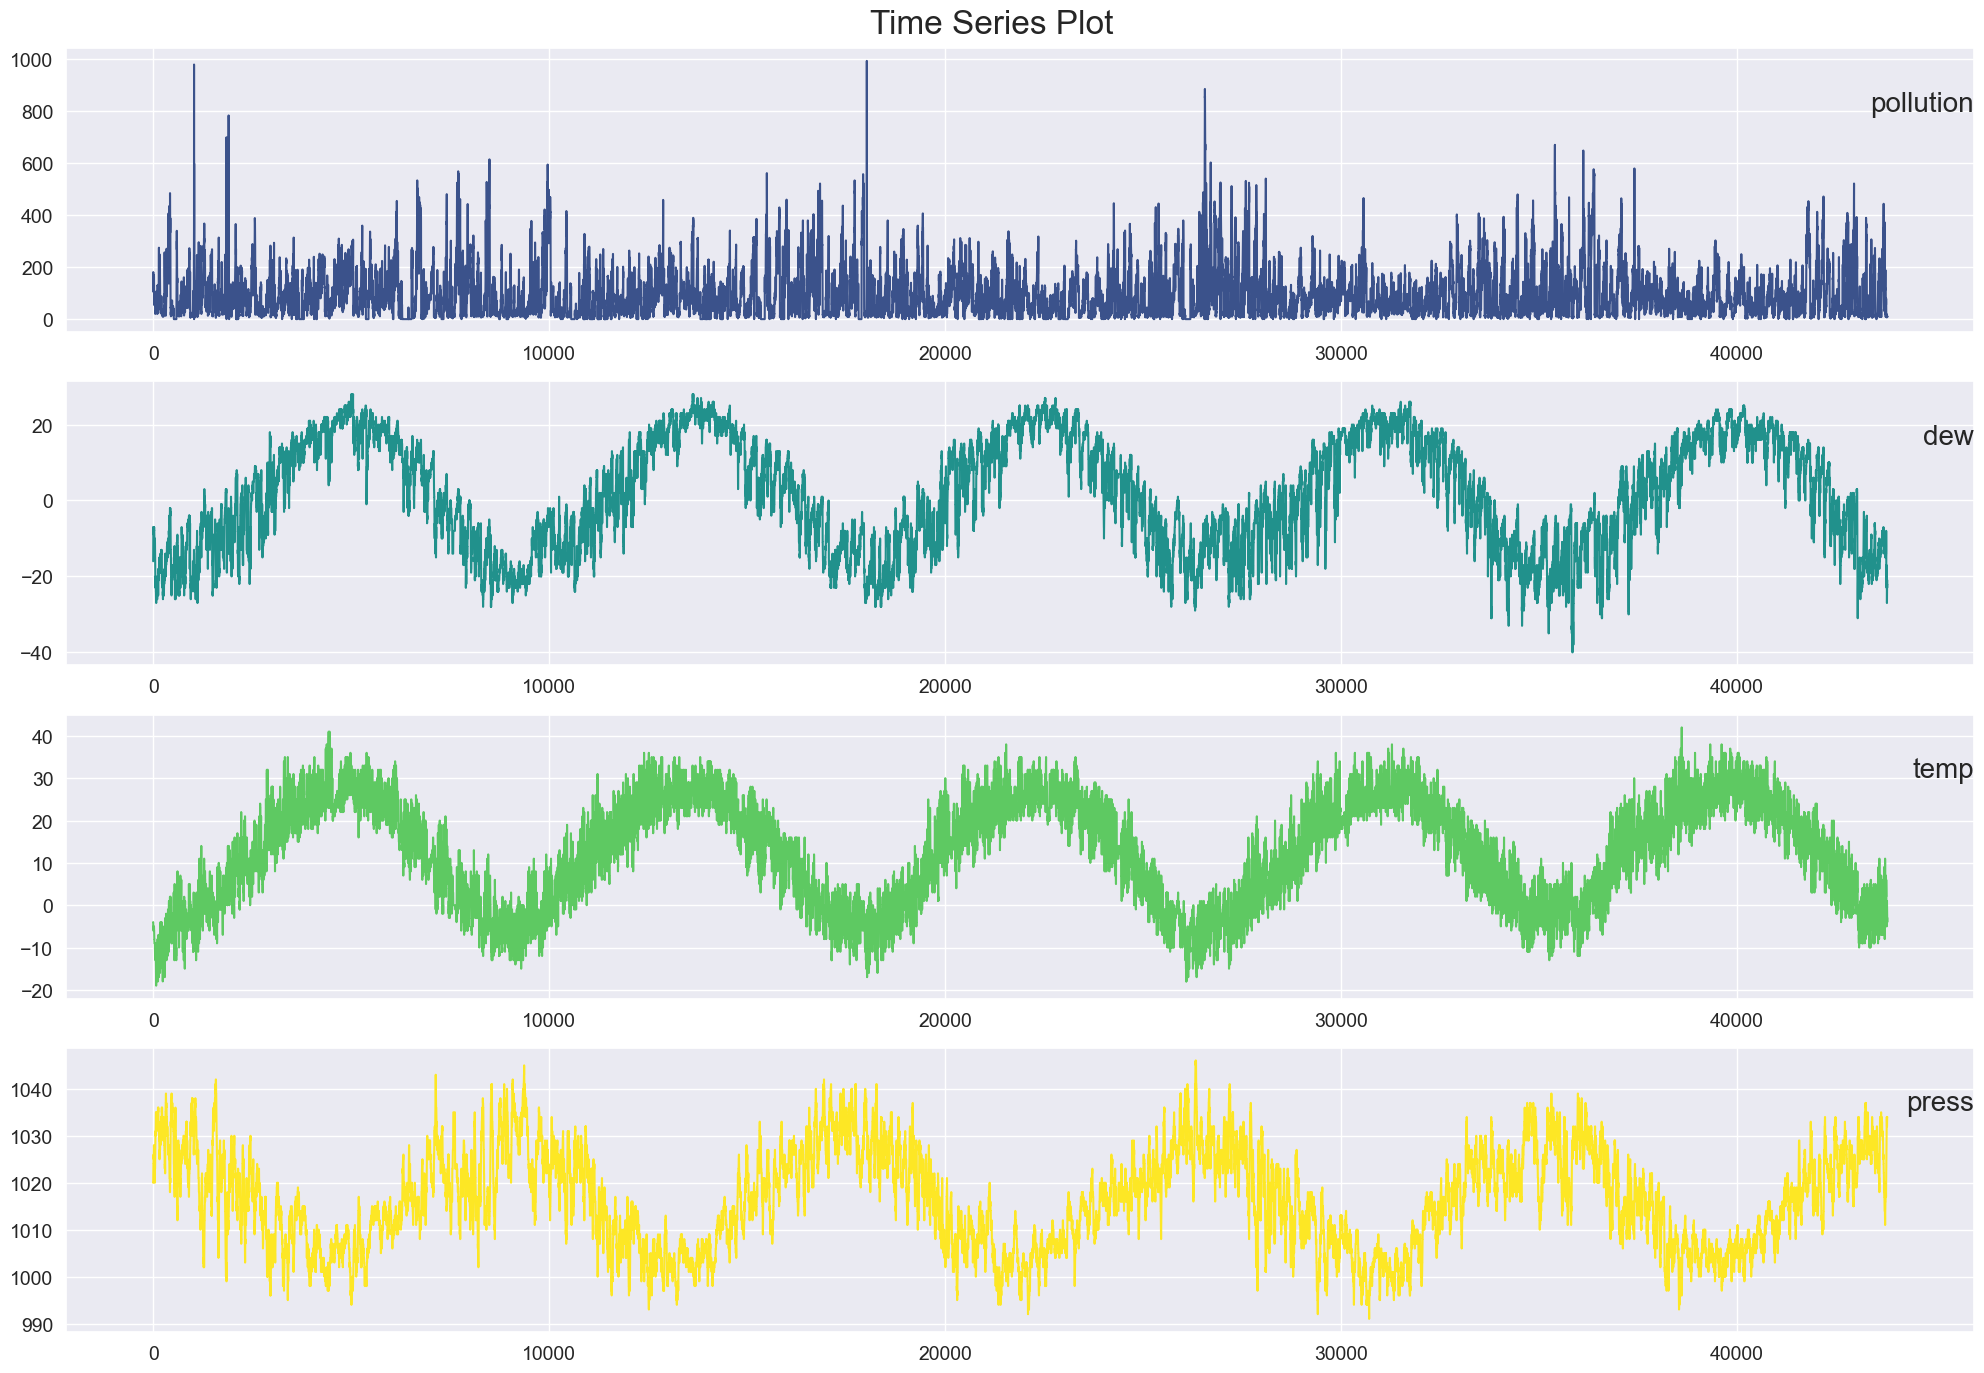

In [241]:
time_vals = ['pollution', 'dew',	'temp',	'press']
fig, axs = plt.subplots(len(time_vals), 1, figsize=(20, 14), facecolor='white')
i = 1
for col, ax in zip(time_vals, axs):
    ax.plot(df[col].values, color=cm.viridis(i/len(time_vals)))
    ax.set_title(col, y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    i += 1

plt.suptitle('Time Series Plot', fontsize=24)
plt.tight_layout()
plt.show()

In [242]:
print(
    f"Snow>0: {df[df['snow'] > 0].shape}",
    f"Rain>0: {df[df['rain'] > 0].shape}",
    sep='\n')

Snow>0: (368, 9)
Rain>0: (1808, 9)


In [243]:
df['rain'] = df['rain'].apply(lambda x: 1 if x > 0 else 0)
df['snow'] = df['snow'].apply(lambda x: 1 if x > 0 else 0)

In [244]:
df['wnd_spd'] = np.log(df['wnd_spd'])

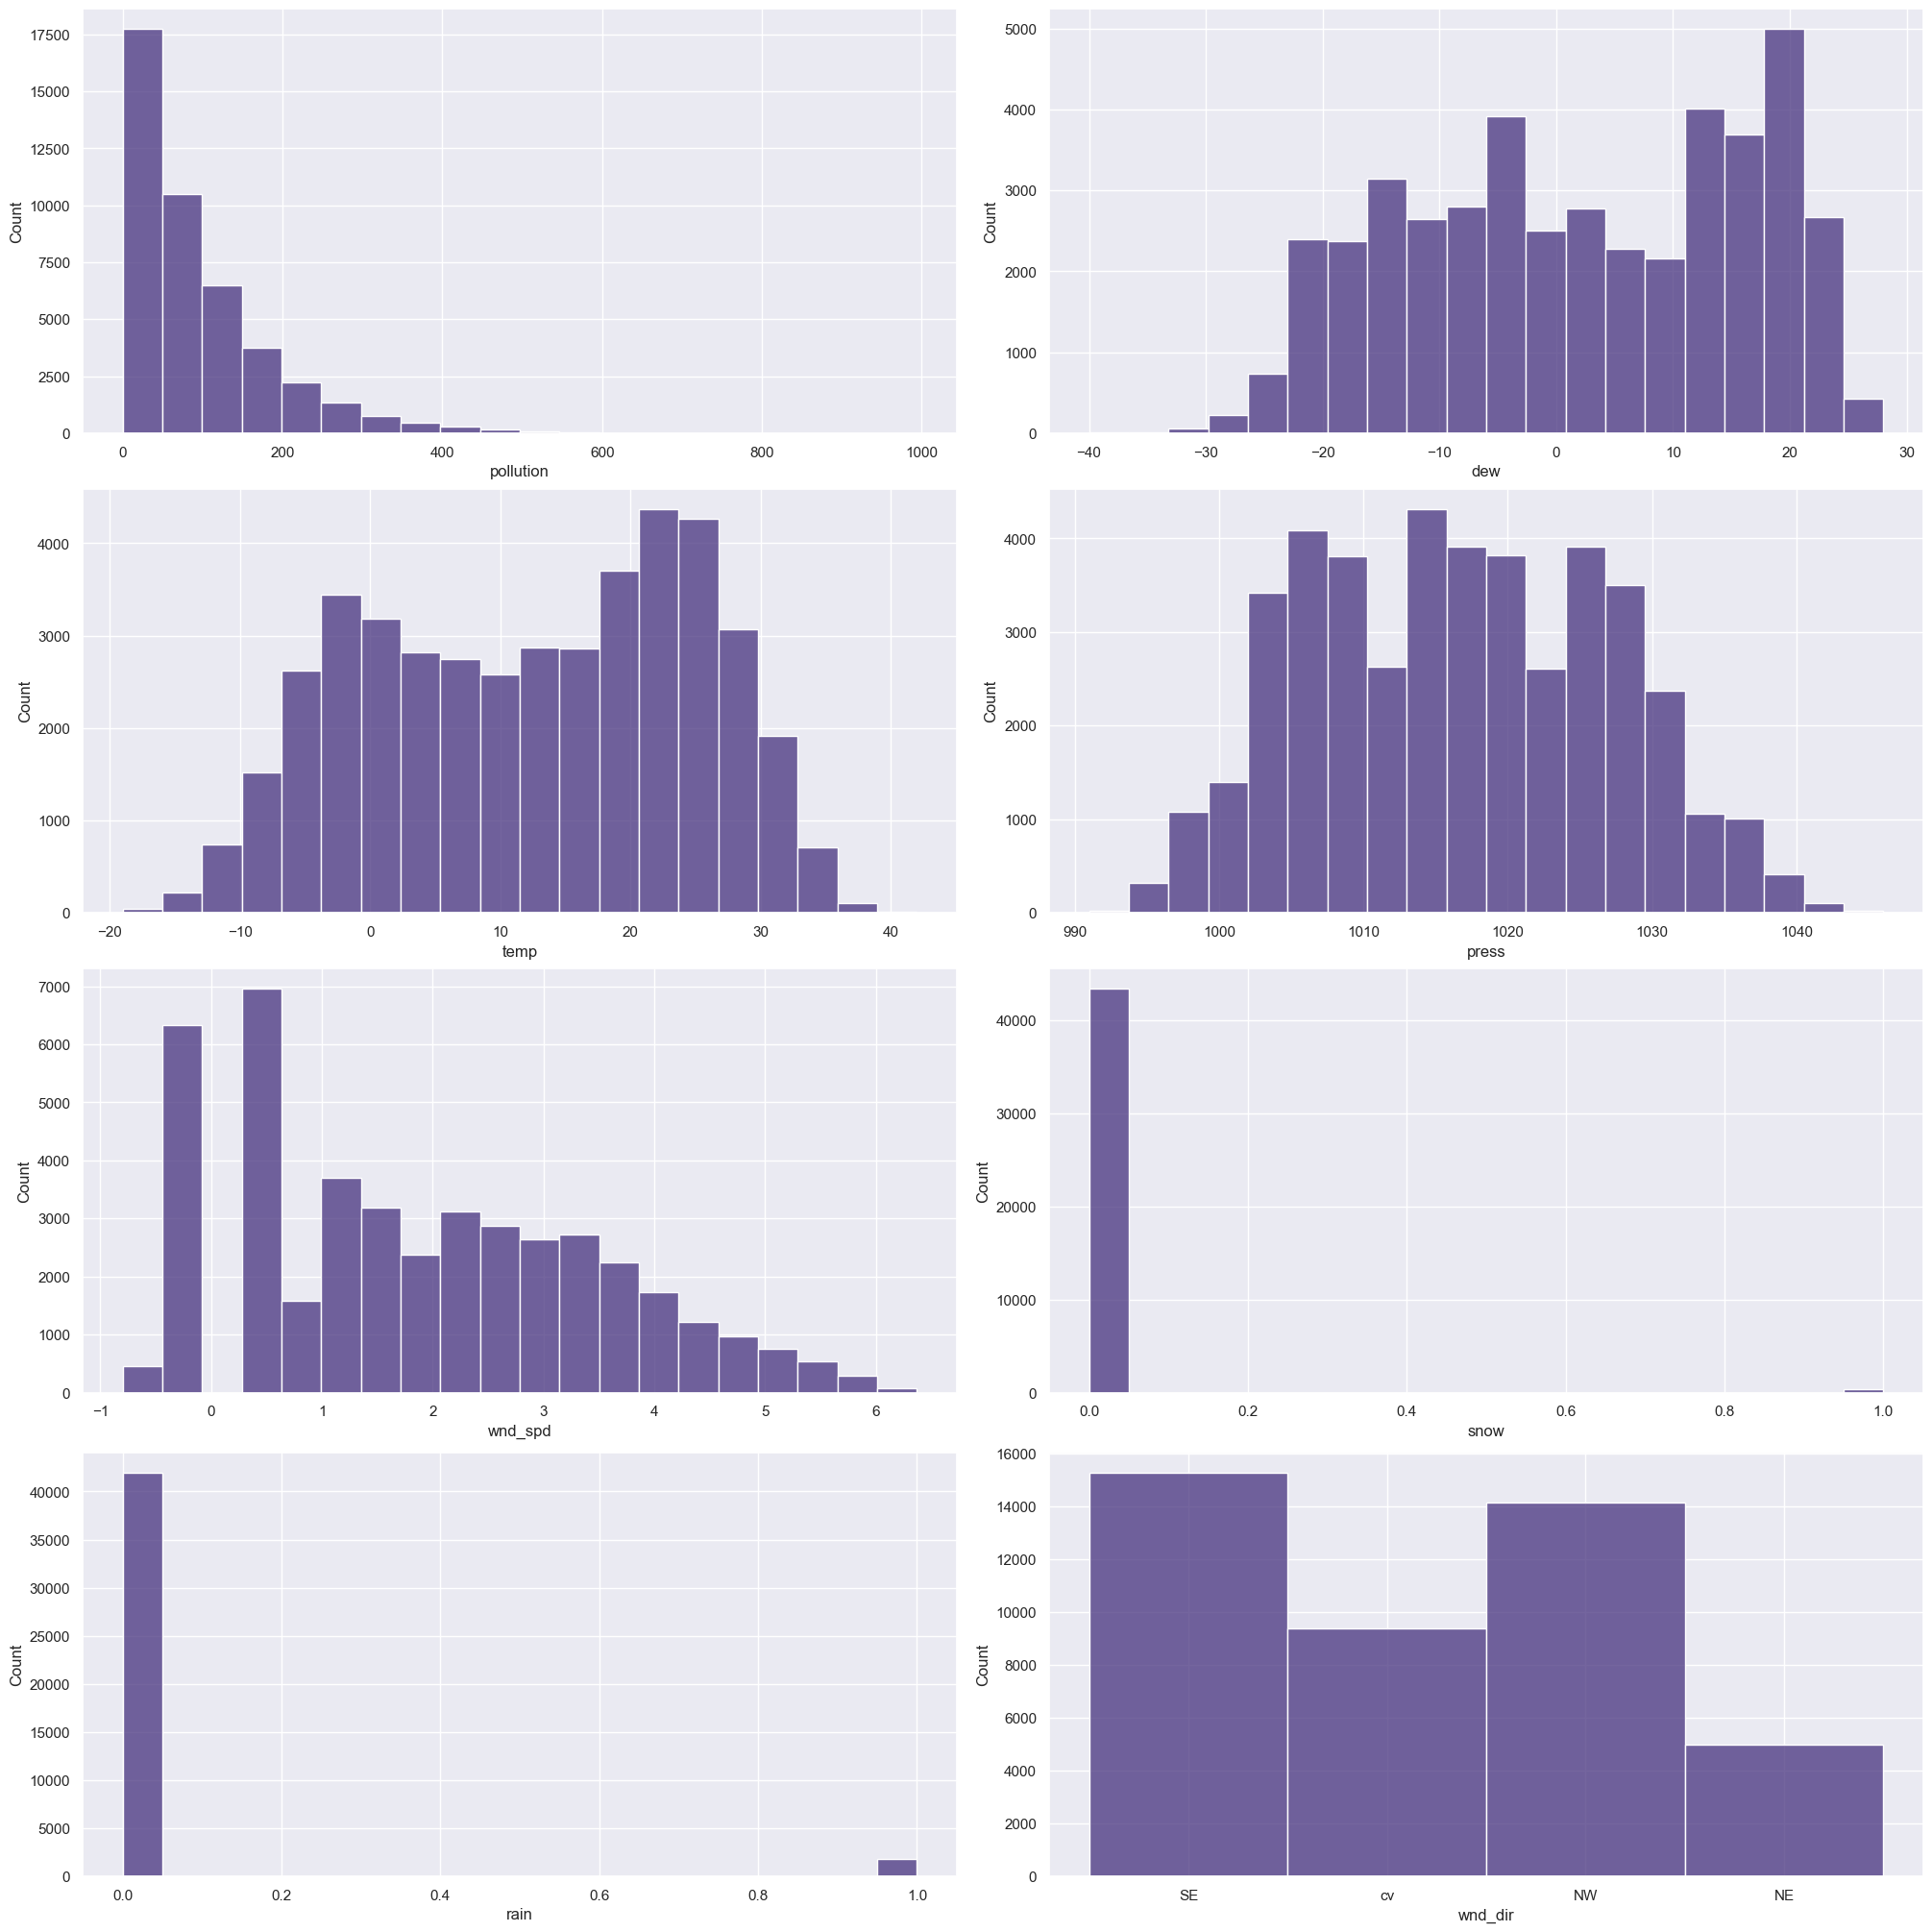

In [245]:
numerical = ['pollution',	'dew',	'temp',	'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(4, 2,
                        figsize=(20, 20), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.histplot(x=f, data=df,
                 ax=axs[i//2][i % 2], bins=20,
                 palette=sns.color_palette("viridis", 2))
sns.histplot(x='wnd_dir', data=df)

plt.show()

In [246]:
df = pd.get_dummies(
    data=df, columns=['wnd_dir'])
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0.582216,0,0,False,False,True,False
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0.985817,0,0,False,False,True,False
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1.272566,0,0,False,False,True,False
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1.678964,1,0,False,False,True,False
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1.832581,1,0,False,False,True,False


In [247]:
df_test = pd.read_csv("pollution_test_data1.csv")
df_test['rain'] = df_test['rain'].apply(lambda x: 1 if x > 0 else 0)
df_test['snow'] = df_test['snow'].apply(lambda x: 1 if x > 0 else 0)
df_test['wnd_spd'] = np.log(df_test['wnd_spd'])
df_test = pd.get_dummies(
    data=df_test, columns=['wnd_dir'])
df_test.head()

,dew,temp,press,wnd_spd,snow,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,-16,4,1027,1.275363,0,0,128,False,False,True,False
1,-17,5,1027,2.028148,0,0,77,False,False,True,False
2,-16,4,1027,2.239645,0,0,65,False,False,True,False
3,-16,1,1028,-0.116534,0,0,79,False,False,False,True
4,-14,0,1028,0.582216,0,0,93,True,False,False,False


In [248]:
scaler = MinMaxScaler()
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir_NE", "wnd_dir_NW",	"wnd_dir_SE",	"wnd_dir_cv", 'wnd_spd',
            'snow', 'rain'])

df_train_scaled = df.copy()
df_test_scaled = df_test.copy()

df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

df_train_scaled.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.192539,0.0,0.0,0.0,0.0,1.0,0.0
1,2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.248820,0.0,0.0,0.0,0.0,1.0,0.0
2,2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.288807,0.0,0.0,0.0,0.0,1.0,0.0
3,2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.345478,1.0,0.0,0.0,0.0,1.0,0.0
4,2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.366899,1.0,0.0,0.0,0.0,1.0,0.0


In [249]:
df_test_scaled.head()

,dew,temp,press,wnd_spd,snow,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.352941,0.377049,0.654545,0.289197,0.0,0.0,0.128773,0.0,0.0,1.0,0.0
1,0.338235,0.393443,0.654545,0.394171,0.0,0.0,0.077465,0.0,0.0,1.0,0.0
2,0.352941,0.377049,0.654545,0.423664,0.0,0.0,0.065392,0.0,0.0,1.0,0.0
3,0.352941,0.327869,0.672727,0.095100,0.0,0.0,0.079477,0.0,0.0,0.0,1.0
4,0.382353,0.311475,0.672727,0.192539,0.0,0.0,0.093561,1.0,0.0,0.0,0.0


In [250]:
df_train_scaled.drop(columns=["date"], inplace=True)

In [251]:
df_train_scaled.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv'],
      dtype='object')

In [252]:
df_test_scaled = df_test_scaled.reindex(columns=df_train_scaled.columns)

In [253]:
# Define the window size
window_size = 11

# -------------------------TrainSet---------------------------------

# Initialize empty lists to store X and Y
X_sequences = []
Y_values = []

# Iterate through the DataFrame to create sequences
for i in range(len(df_train_scaled) - window_size):
    X_seq = df_train_scaled.iloc[i:i+window_size].values
    Y_val = df_train_scaled.iloc[i+window_size]['pollution']
    X_sequences.append(X_seq)
    Y_values.append(Y_val)

# Convert the lists to NumPy arrays for modeling
X_train = np.array(X_sequences)
y_train = np.array(Y_values)

# -------------------------TestSet---------------------------------

# Initialize empty lists to store X and Y
X_sequences = []
Y_values = []

# Iterate through the DataFrame to create sequences
for i in range(len(df_test_scaled) - window_size):
    X_seq = df_test_scaled.iloc[i:i+window_size].values
    Y_val = df_test_scaled.iloc[i+window_size]['pollution']
    X_sequences.append(X_seq)
    Y_values.append(Y_val)

# Convert the lists to NumPy arrays for modeling
X_test = np.array(X_sequences)
y_test = np.array(Y_values)

# -----------------------------------------------------------------
print("Train size : ", X_train.shape, y_train.shape, "\n ------- \n"
      "Test Size : ", X_test.shape, y_test.shape)

Train size :  (43789, 11, 11) (43789,) 
 ------- 
Test Size :  (335, 11, 11) (335,)


In [254]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [255]:
model = Sequential()
model.add(LSTM(32, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),
              metrics=[RootMeanSquaredError()])

# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 11, 32)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,785 (34.32 KB)

 Trainable params: 8,785 (34.32 KB)

 Non-trainable params: 0 (0.00 B)

In [256]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0065 - root_mean_squared_error: 0.0795 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 2/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0483 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 3/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0393 - val_loss: 8.3767e-04 - val_root_mean_squared_error: 0.0290
Epoch 4/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 5.8438e-04 - val_root_mean_squared_error: 0.0242
Epoch 5/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9.8886e-04 - root_mean_squared_error: 0.0313 - val_loss: 5.5185e-04 - val_root_mean_squared_error: 0.0235
Epoch 6/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.8454e-04 - root_mean_squared_error: 0.0312 - val_loss: 5.2722e-04 - val_root_mean_squared_error: 0.0230
Epoch 7/10
1232/

In [257]:
best_model = load_model('best_model.keras')

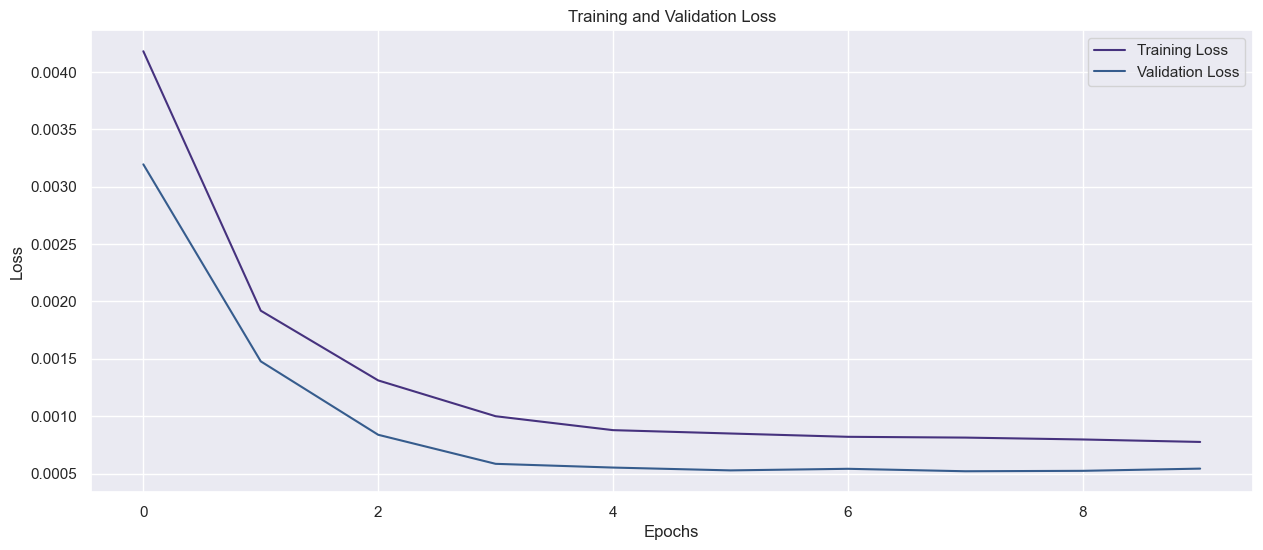

In [258]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [259]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual': y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,Train Predictions,Actual
0,0.158915,0.171026
1,0.149278,0.160966
2,0.135344,0.146881
3,0.122030,0.125755
4,0.103122,0.130785


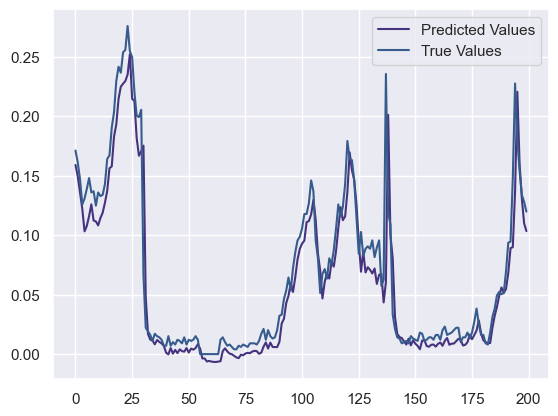

In [260]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [261]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(16, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),
              metrics=[RootMeanSquaredError()])

In [262]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0054 - root_mean_squared_error: 0.0725 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 2/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 8.8226e-04 - val_root_mean_squared_error: 0.0297
Epoch 3/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 7.6030e-04 - val_root_mean_squared_error: 0.0276
Epoch 4/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 7.4125e-04 - val_root_mean_squared_error: 0.0272
Epoch 5/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 6.8630e-04 - val_root_mean_squared_error: 0.0262
Epoch 6/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 7.2286e-04 - val_root_mean_squared_error: 0.0269
Epoch 7/10
1232/1232

In [263]:
best_model = load_model('best_model.keras')
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual': y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,Train Predictions,Actual
0,0.158915,0.171026
1,0.149278,0.160966
2,0.135344,0.146881
3,0.122030,0.125755
4,0.103122,0.130785


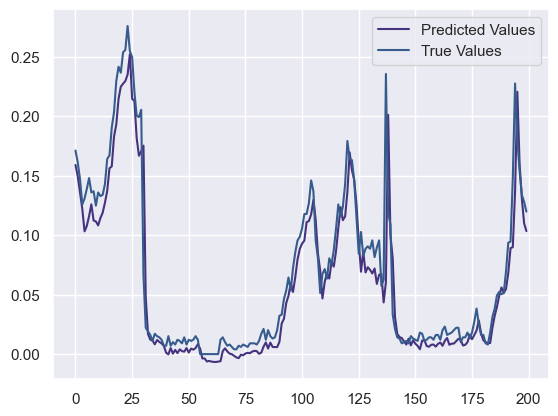

In [264]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [265]:
model = Sequential()
model.add(LSTM(32, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),
              metrics=[RootMeanSquaredError()])

In [266]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0069 - root_mean_squared_error: 0.0812 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 2/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.0560 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 3/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 4/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 8.3712e-04 - val_root_mean_squared_error: 0.0289
Epoch 5/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 6.9589e-04 - val_root_mean_squared_error: 0.0264
Epoch 6/10
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 5.9416e-04 - val_root_mean_squared_error: 0.0244
Epoch 7/10
1232/1232 ━━━━━━━

In [267]:
best_model = load_model('best_model.keras')
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual': y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,Train Predictions,Actual
0,0.158915,0.171026
1,0.149278,0.160966
2,0.135344,0.146881
3,0.122030,0.125755
4,0.103122,0.130785


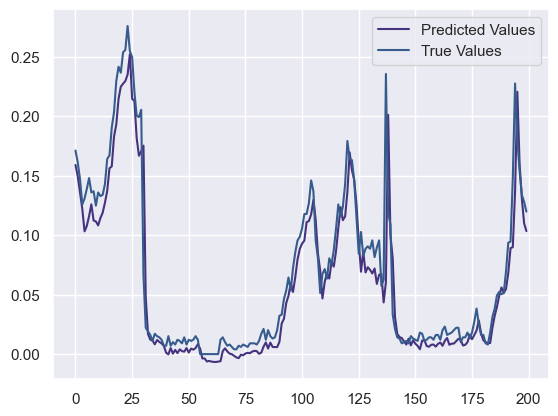

In [268]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()